# Model Tree with Ridge Regression

### Setup

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint, loguniform

In [17]:
# Load Data
X_train = pd.read_csv("../data/X_train_nz_scaled.csv")
y_train = pd.read_csv("../data/y_train_nz.csv").iloc[:, 0]
X_test = pd.read_csv("../data/X_test_nz_scaled.csv")
y_test = pd.read_csv("../data/y_test_nz.csv").iloc[:, 0]

### Initialize Model

In [18]:

# MODEL TREE WITH RIDGE REGRESSION
class RidgeModelTreeRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, max_depth=5, min_samples_leaf=10, ridge_alpha=1.0):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.ridge_alpha = ridge_alpha
        self.tree = None
        self.leaf_models = {}

    def fit(self, X, y):
        self.tree = DecisionTreeRegressor(
            max_depth=self.max_depth, 
            min_samples_leaf=self.min_samples_leaf
        )
        self.tree.fit(X, y)
        leaf_ids = self.tree.apply(X)
        self.leaf_models = {}
        
        for leaf in np.unique(leaf_ids):
            idx = np.where(leaf_ids == leaf)[0]
            X_leaf = X.iloc[idx] if isinstance(X, pd.DataFrame) else X[idx]
            y_leaf = y.iloc[idx] if isinstance(y, pd.Series) else y[idx]

            ridge = Ridge(alpha=self.ridge_alpha)
            ridge.fit(X_leaf, y_leaf)
            self.leaf_models[leaf] = ridge
        return self

    def predict(self, X):
        leaf_ids = self.tree.apply(X)
        preds = np.zeros(len(X))
        for i, leaf in enumerate(leaf_ids):
            X_i = X.iloc[[i]] if isinstance(X, pd.DataFrame) else X[i:i+1]
            preds[i] = self.leaf_models[leaf].predict(X_i)[0]
        return preds


### Hyperparameter Optimization

In [19]:
# HYPERPARAMETER OPTIMIZATION
param_dist = {
    "max_depth": [None, 3, 5, 7, 9],
    "min_samples_leaf": [5, 10, 20, 50, 100, 200],
    "ridge_alpha": loguniform(1e-2, 1e2)
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)


# 4) Random search instead of grid search
random_search = RandomizedSearchCV(
    estimator=RidgeModelTreeRegressor(),
    param_distributions=param_dist,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_iter=200,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Running Grid Search for Ridge Model Tree...")
random_search.fit(X_train, y_train)

print("\nBest params:", random_search.best_params_)
print("Best CV score (neg MSE):", random_search.best_score_)


Running Grid Search for Ridge Model Tree...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END max_depth=7, min_samples_leaf=100, ridge_alpha=0.05416754583247458; total time=   6.4s
[CV] END max_depth=9, min_samples_leaf=100, ridge_alpha=0.04207988669606638; total time=   6.3s
[CV] END max_depth=7, min_samples_leaf=100, ridge_alpha=0.05416754583247458; total time=   6.4s
[CV] END max_depth=7, min_samples_leaf=100, ridge_alpha=0.05416754583247458; total time=   6.5s
[CV] END max_depth=9, min_samples_leaf=100, ridge_alpha=0.04207988669606638; total time=   6.5s
[CV] END max_depth=7, min_samples_leaf=100, ridge_alpha=0.05416754583247458; total time=   6.6s
[CV] END max_depth=7, min_samples_leaf=100, ridge_alpha=0.05416754583247458; total time=   6.5s
[CV] END max_depth=9, min_samples_leaf=100, ridge_alpha=0.04207988669606638; total time=   6.6s
[CV] END max_depth=9, min_samples_leaf=100, ridge_alpha=0.04207988669606638; total time=   6.6s
[CV] END max_depth=9, min_sa

### Single Model Tree (best parameter)

  MAE:  12.19
  RMSE: 15.64
R^2 :  0.2491


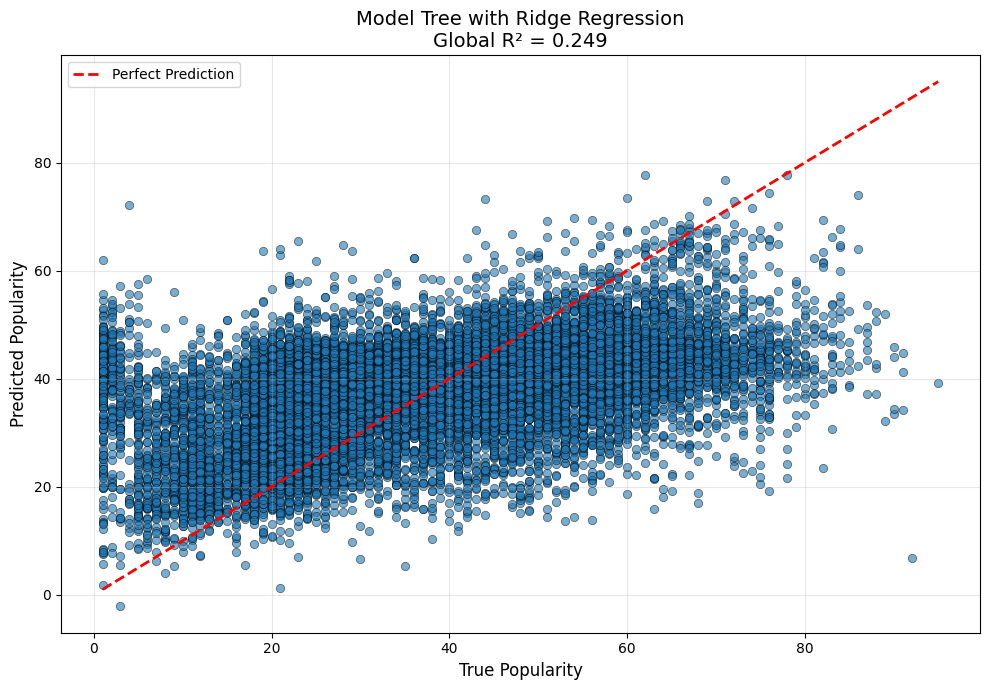

In [20]:
# SINGLE RIDGE MODEL TREE (with best params)

best_mt_ridge = RidgeModelTreeRegressor(**random_search.best_params_)
best_mt_ridge.fit(X_train, y_train)
y_pred_mt_ridge = best_mt_ridge.predict(X_test)


r2 = r2_score(y_test, y_pred_mt_ridge)
mae = mean_absolute_error(y_test, y_pred_mt_ridge)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_mt_ridge))

print(f"  MAE:  {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"R^2 :  {r2:.4f}")


# Visualization: Single Ridge Model Tree
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred_mt_ridge, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Popularity', fontsize=12)
plt.ylabel('Predicted Popularity', fontsize=12)
plt.title(f'Model Tree with Ridge Regression\nGlobal R² = {r2:.3f}', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Random Forest

In [21]:
# RANDOM FOREST OF RIDGE MODEL TREES

base_mt_ridge = RidgeModelTreeRegressor(**random_search.best_params_)

rf_mt_ridge = BaggingRegressor(
    estimator=base_mt_ridge,
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    bootstrap=True
)

print("\nTraining Random Forest of Ridge Model Trees...")
rf_mt_ridge.fit(X_train, y_train)
y_pred_rf_mt_ridge = rf_mt_ridge.predict(X_test)


r2 = r2_score(y_test, y_pred_rf_mt_ridge)
mae = mean_absolute_error(y_test, y_pred_rf_mt_ridge)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_mt_ridge))

print(f"  MAE:  {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"R^2 :  {r2:.4f}")




Training Random Forest of Ridge Model Trees...
  MAE:  11.90
  RMSE: 15.20
R^2 :  0.2914


### Plot Random Forest

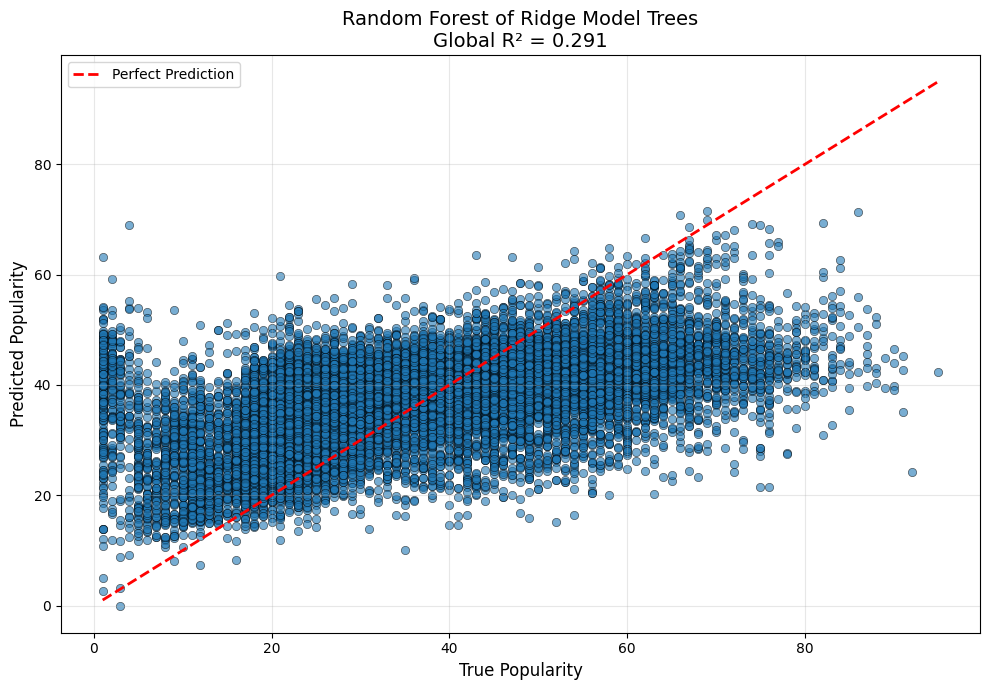

In [22]:
# Visualization: Random Forest of Ridge Model Trees
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred_rf_mt_ridge, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Popularity', fontsize=12)
plt.ylabel('Predicted Popularity', fontsize=12)
plt.title(f'Random Forest of Ridge Model Trees\nGlobal R² = {r2:.3f}', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()